Importing Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import arma_order_select_ic
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from matplotlib.dates import DateFormatter
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import pmdarima as pm
from datetime import timedelta




# 2 Statistical inference

To validate the information about the major effect of coal blasting on air pollution, we can analyze the air quality index (AQI) calculated from the provided dataset. The AQI is calculated based on various pollutants such as PM2.5, PM10, SO2, NOx, NH3, CO, O3, NO, NO2, and Benzene. 

CO in mg/m3 and other pollutants in μg/m3 ,AQI based on 24-hourly average values for PM10, PM2.5, NO2, SO2, NH3, NO,NO2 ,Benzene and 8-hourly values for CO and O3

In [5]:
data_timeseries=pd.read_csv('data_timeseries_op.csv')

In [6]:
dfa=data_timeseries.copy()

#Calculate the rolling averages for PM10, PM2.5, SO2, NOx, and NH3 over a 24-hour window
dfa["PM10_24hr_avg"] = dfa.groupby("From")["PM10"].rolling(window=96, min_periods=1).mean().values
dfa["PM2.5_24hr_avg"] = dfa.groupby("From")["PM2.5"].rolling(window=96, min_periods=1).mean().values
dfa["SO2_24hr_avg"] = dfa.groupby("From")["SO2"].rolling(window=96, min_periods=1).mean().values
dfa["NOx_24hr_avg"] = dfa.groupby("From")["NOX"].rolling(window=96, min_periods=1).mean().values
dfa["NH3_24hr_avg"] = dfa.groupby("From")["NH3"].rolling(window=96, min_periods=1).mean().values
dfa["NO_24hr_avg"] = dfa.groupby("From")["NO"].rolling(window=96, min_periods=1).mean().values
dfa["NO2_24hr_avg"] = dfa.groupby("From")["NO2"].rolling(window=96, min_periods=1).mean().values
dfa["Benzene_24hr_avg"] = dfa.groupby("From")["Benzene"].rolling(window=96, min_periods=1).mean().values
#  Calculate the maximum values for CO and O3 over an 8-hour window
dfa["CO_8hr_max"] = dfa.groupby("From")["CO"].rolling(window=24, min_periods=1).max().values
dfa["O3_8hr_max"] = dfa.groupby("From")["Ozone"].rolling(window=24, min_periods=1).max().values
#  Define the function to calculate the pollutants sub-index

df4=pd.read_csv('data_aqi.csv')
def get_PM25_subindex(x):
    if x <= 30:
        return x * 50 / 30
    elif x <= 60:
        return 50 + (x - 30) * 50 / 30
    elif x <= 90:
        return 100 + (x - 60) * 100 / 30
    elif x <= 120:
        return 200 + (x - 90) * 100 / 30
    elif x <= 250:
        return 300 + (x - 120) * 100 / 130
    elif x > 250:
        return 400 + (x - 250) * 100 / 130
    else:
        return 0

# Step 6: Apply the function to calculate the PM2.5 sub-index
dfa["PM2.5_SubIndex"] = dfa["PM2.5_24hr_avg"].apply(lambda x: get_PM25_subindex(x))
# PM10 Sub-Index calculation
def get_PM10_subindex(x):
    if x <= 50:
        return x
    elif x <= 100:
        return x
    elif x <= 250:
        return 100 + (x - 100) * 100 / 150
    elif x <= 350:
        return 200 + (x - 250)
    elif x <= 430:
        return 300 + (x - 350) * 100 / 80
    elif x > 430:
        return 400 + (x - 430) * 100 / 80
    else:
        return 0

dfa["PM10_SubIndex"] = dfa["PM10_24hr_avg"].apply(lambda x: get_PM10_subindex(x))
# SO2 Sub-Index calculation
def get_SO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 380:
        return 100 + (x - 80) * 100 / 300
    elif x <= 800:
        return 200 + (x - 380) * 100 / 420
    elif x <= 1600:
        return 300 + (x - 800) * 100 / 800
    elif x > 1600:
        return 400 + (x - 1600) * 100 / 800
    else:
        return 0

dfa["SO2_SubIndex"] = dfa["SO2_24hr_avg"].apply(lambda x: get_SO2_subindex(x))
# NOx Sub-Index calculation
def get_NOx_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

dfa["NOX_SubIndex"] = dfa["NOx_24hr_avg"].apply(lambda x: get_NOx_subindex(x))
# NH3 Sub-Index calculation
def get_NH3_subindex(x):
    if x <= 200:
        return x * 50 / 200
    elif x <= 400:
        return 50 + (x - 200) * 50 / 200
    elif x <= 800:
        return 100 + (x - 400) * 100 / 400
    elif x <= 1200:
        return 200 + (x - 800) * 100 / 400
    elif x <= 1800:
        return 300 + (x - 1200) * 100 / 600
    elif x > 1800:
        return 400 + (x - 1800) * 100 / 600
    else:
        return 0

dfa["NH3_SubIndex"] = dfa["NH3_24hr_avg"].apply(lambda x: get_NH3_subindex(x))
# CO Sub-Index calculation
def get_CO_subindex(x):
    if x <= 1:
        return x * 50 / 1
    elif x <= 2:
        return 50 + (x - 1) * 50 / 1
    elif x <= 10:
        return 100 + (x - 2) * 100 / 8
    elif x <= 17:
        return 200 + (x - 10) * 100 / 7
    elif x <= 34:
        return 300 + (x - 17) * 100 / 17
    elif x > 34:
        return 400 + (x - 34) * 100 / 17
    else:
        return 0

dfa["CO_SubIndex"] = dfa["CO_8hr_max"].apply(lambda x: get_CO_subindex(x))
# O3 Sub-Index calculation
def get_O3_subindex(x):
    if x <= 50:
        return x * 50 / 50
    elif x <= 100:
        return 50 + (x - 50) * 50 / 50
    elif x <= 168:
        return 100 + (x - 100) * 100 / 68
    elif x <= 208:
        return 200 + (x - 168) * 100 / 40
    elif x <= 748:
        return 300 + (x - 208) * 100 / 539
    elif x > 748:
        return 400 + (x - 400) * 100 / 539
    else:
        return 0

dfa["Ozone_SubIndex"] = dfa["O3_8hr_max"].apply(lambda x: get_O3_subindex(x))
# NO Sub-Index calculation
def get_NO_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

dfa["NO_SubIndex"] = dfa["NO_24hr_avg"].apply(lambda x: get_NO_subindex(x))
# NO2 Sub-Index calculation
def get_NO2_subindex(x):
    if x <= 40:
        return x * 50 / 40
    elif x <= 80:
        return 50 + (x - 40) * 50 / 40
    elif x <= 180:
        return 100 + (x - 80) * 100 / 100
    elif x <= 280:
        return 200 + (x - 180) * 100 / 100
    elif x <= 400:
        return 300 + (x - 280) * 100 / 120
    elif x > 400:
        return 400 + (x - 400) * 100 / 120
    else:
        return 0

dfa["NO2_SubIndex"] = dfa["NO2_24hr_avg"].apply(lambda x: get_NO2_subindex(x))
# Benzene Sub-Index calculation
def get_benzene_subindex(x):
    if x <= 5:
        return x
    elif x <= 10:
        return x
    elif x <= 20:
        return 100 + (x - 10) * 100 / 10
    elif x <= 30:
        return 200 + (x - 20) * 100 / 10
    elif x <= 40:
        return 300 + (x - 30) * 100 / 10
    elif x > 40:
        return 400 + (x - 40) * 100 / 10
    else:
        return 0

dfa["Benzene_SubIndex"] = dfa["Benzene_24hr_avg"].apply(lambda x: get_benzene_subindex(x))

dfa["Checks"] = (dfa["PM2.5_SubIndex"] > 0).astype(int) + \
                (dfa["PM10_SubIndex"] > 0).astype(int) + \
                (dfa["SO2_SubIndex"] > 0).astype(int) + \
                (dfa["NOX_SubIndex"] > 0).astype(int) + \
                (dfa["NH3_SubIndex"] > 0).astype(int) + \
                (dfa["CO_SubIndex"] > 0).astype(int) + \
                (dfa["NO_SubIndex"] > 0).astype(int) + \
                (dfa["NO2_SubIndex"] > 0).astype(int) + \
                (dfa["Benzene_SubIndex"] > 0).astype(int) + \
                (dfa["Ozone_SubIndex"] > 0).astype(int) 
                
                
dfa["AQI_calculated"] = dfa[["PM2.5_SubIndex", "PM10_SubIndex", "SO2_SubIndex", "NOX_SubIndex",
                           "NH3_SubIndex", "CO_SubIndex", "Ozone_SubIndex","NO_SubIndex","NO2_SubIndex","Benzene_SubIndex"]].max(axis=1)


dfa.loc[dfa["PM2.5_SubIndex"] + dfa["PM10_SubIndex"] <= 0, "AQI_calculated"] = np.NaN

dfa.loc[dfa.Checks < 3, "AQI_calculated"] = np.NaN
dfa2=dfa.copy()
dfa["AQI_calculated"]=df4['AQI']
dfa["AQI_calculated"]

0         0.000000
1         0.000000
2         0.000000
3         0.000000
4         0.000000
           ...    
8635    111.944985
8636    111.976235
8637    112.010610
8638    112.040818
8639    112.072068
Name: AQI_calculated, Length: 8640, dtype: float64

* The first part of the code calculates the rolling averages for PM10, PM2.5, SO2, NOx,NO ,NO2 , Benzene and NH3 over a 24-hour window.
* The second part of the code calculates the maximum values for CO and O3 over an 8-hour window.
* The third part of the code defines a function for calculating the sub-index for each pollutant. The sub-index is a number between 0 and 500, where 0 indicates good air quality and 500 indicates hazardous air quality.
* The fourth part of the code applies the function to calculate the sub-indices for each pollutant.
* The final AQI is the maximum Sub-Index among the available sub-indices with the condition that at least one of PM2.5 and PM10 should be available and at least three out of the seven should be available.

* There is no theoretical upper value of AQI but its rare to find values over 1000.

In [7]:
#saving the df
# dfa.to_csv('data_aqi.csv')

To validate the information regarding the impact of coal blasting on air pollution, we can perform a time series analysis using actual observed data. By grouping the AQI (Air Quality Index) values by the 'Time' column and calculating the average, we can analyze the trend in air pollution levels before and after the blasting period.



In [8]:
# Convert 'From' column to datetime data type
dfa['From'] = pd.to_datetime(dfa['From'])

# Extract the time component from 'From' column
dfa['Time'] = dfa['From'].dt.time

# Group the AQI values by 'Time' column and calculate the average
df_daily = dfa.groupby('Time').mean()

# Create a line plot for the AQI values throughout the day
trace = go.Scatter(
    x=df_daily.index,
    y=df_daily["AQI_calculated"],
    mode="lines",
    name="AQI"
)


layout = go.Layout(
    title="AQI Values Throughout the Day",
    xaxis=dict(title="Time"),
    yaxis=dict(title="AQI")
)


fig = go.Figure(data=[trace], layout=layout)
fig.show()


Should we remove sundays from our analysis?

In [9]:
dfa['From'] = pd.to_datetime(dfa['From'])
df_sunday = dfa[dfa['From'].dt.dayofweek == 6]  # 0: Monday, 6: Sunday

# Convert 'From' column to datetime data type
df_sunday['From'] = pd.to_datetime(df_sunday['From'])

# Extract the time component from 'From' column
df_sunday['Time'] = df_sunday['From'].dt.time

# Group the AQI values by 'Time' column and calculate the average
df_daily_sunday = df_sunday.groupby('Time').mean()

# Create a line plot for the AQI values throughout the day
trace = go.Scatter(
    x=df_daily.index,
    y=df_daily_sunday["AQI_calculated"],
    mode="lines",
    name="AQI"
)

# Create the layout for the plot
layout = go.Layout(
    title="AQI Values Throughout the Day",
    xaxis=dict(title="Time"),
    yaxis=dict(title="AQI")
)

# Combine the trace and layout into a figure and display the plot
fig = go.Figure(data=[trace], layout=layout)
fig.show()


Yes we should exclude Sundays and gov. holidays like holi , republic day etc mentioned by coal india in this link
https://www.centralcoalfields.in/hindi/indsk/pdf/holidays_list_2023.pdf

In [10]:

dfa['From'] = pd.to_datetime(dfa['From'])

# list of holiday dates
holidays = ['2023-01-26', '2023-03-08', '2023-03-30', '2023-04-07', '2023-04-14', '2023-04-22', '2023-05-01']

# Filter out rows corresponding to Sundays and holidays
df_filtered = dfa[(dfa['From'].dt.dayofweek != 6) &  (~dfa['From'].dt.date.isin(holidays))]
# df_filtered.to_csv('data_with_holiday_removed.csv')

df_filtered['Time'] = df_filtered['From'].dt.time

# Group the AQI values by 'Time' column and calculate the average
df_daily_filtered = df_filtered.groupby('Time').mean()

# Create a line plot for the AQI values throughout the day
trace = go.Scatter(
    x=df_daily_filtered.index,
    y=df_daily_filtered["AQI_calculated"],
    mode="lines",
    name="AQI"
)

# Create the layout for the plot
layout = go.Layout(
    title="AQI Values Throughout the Day",
    xaxis=dict(title="Time"),
    yaxis=dict(title="AQI")
)

# Combine the trace and layout into a figure and display the plot
fig = go.Figure(data=[trace], layout=layout)
fig.show()


After analyzing the data, it was observed that the average AQI values were relatively lower before the blasting period, indicating relatively better air quality. However, there was a noticeable increase in the average AQI values after the blasting, suggesting a potential impact on air pollution.

This analysis provides evidence that the coal blasting activity during the specified time period (13:45 pm to 14:45 pm) has a significant effect on air pollution, resulting in higher AQI values. It highlights the importance of considering the timing of such activities to better understand and mitigate their impact on air quality

Upon further analysis of the observed data, it was observed that there was a relatively little increase in AQI (Air Quality Index) during the time of the coal blasting, indicating a temporary stabilization of air pollution levels during the blasting period. This can be attributed to the immediate dispersion of pollutants caused by the blasting activity.

However, it is important to note that the AQI values started to increase gradually from the blasting period. This suggests that although there may be a temporary respite in air pollution during the blasting, the release of pollutants continues to have a lingering impact on air quality. The increase in AQI values after the blast indicates the presence of pollutants that take some time to disperse and contribute to higher pollution levels.

Therefore, the observed data supports the notion that there will be a AQI will start increasing at the time of the blast, followed by a subsequent major increase in air pollution levels after a certain period. This highlights the significance of monitoring air quality both during and after blasting activities to assess their overall impact on the environment and public health.

In [11]:
trace = go.Scatter(
    x=dfa['From'],
    y=dfa["AQI_calculated"],
    mode="lines",
    name="Weighted Factors"
)

layout = go.Layout(
    title="Weighted Factored Time Series",
    xaxis=dict(title="Date"),
    yaxis=dict(title="Weighted Factored")
)

fig = go.Figure(data=[trace], layout=layout)
fig.show()


The Air Quality Index (AQI) can be a suitable metric to represent the combined weighted time-series data. AQI is a composite index that provides a single value representing the overall air quality based on various air pollutants. By combining the weighted time-series data for multiple air polluting factors, the resulting AQI captures the pollution effect of blasting in a comprehensive manner.

Using AQI as the combined metric has several advantages:
1. Simplification: AQI simplifies the multiple air polluting factors into a single numerical value, making it easier to interpret and compare pollution levels.
2. Standardization: AQI is a standardized metric that is widely used and understood. It allows for consistent comparisons across different locations and time periods.
3. Health Impact: AQI is designed to reflect the potential health impact of air pollution. It considers the concentrations of different pollutants and their corresponding health effects, providing a meaningful representation of the pollution effect of blasting on human health.

By deriving the combined weighted time-series data and representing it using the AQI, we can effectively capture the pollution effect of blasting while considering the contributions of multiple air polluting factors.

The blasting time can be detected by analyzing the peaks in the time-series data. In the code, we identify the peaks by comparing the smoothed combined score with its preceding value. Peaks represent significant increases in pollution levels and can indicate the occurrence of blasting activities. By comparing the detected peaks with the known blasting time range, we can validate the blasting time and identify the specific time intervals when blasting is likely to have occurred and we have considering that it will take 30 min for the sensor to detect the pollution as it is situated futher away from the site of explosion.

In [12]:
import datetime

expected_blast_start = pd.to_datetime('14:15').time()
expected_blast_end = pd.to_datetime('15:15').time()

# Convert '02:00' to a timedelta object
time_diff = datetime.datetime.strptime('00:30', '%H:%M') - datetime.datetime(1900, 1, 1)

blasting_times = []
for date in pd.unique(dfa['From'].dt.date):
    daily_data = dfa[dfa['From'].dt.date == date]  # Filter data for a specific day
    peaks = np.where((daily_data['From'].dt.time >= expected_blast_start) &
                     (daily_data['From'].dt.time <= expected_blast_end) &
                     (daily_data['AQI_calculated'] > daily_data['AQI_calculated'].shift(1)))[0]
    peak_times = daily_data['From'].iloc[peaks]
    blasting_times.extend(peak_times - time_diff)

# Convert blasting times to datetime objects
blasting_times = pd.to_datetime(blasting_times)

# Print the detected blasting times
print("Detected blasting times:")
for blasting_time in blasting_times:
    print(blasting_time)


Detected blasting times:
2023-02-02 13:45:00
2023-02-02 14:00:00
2023-02-02 14:15:00
2023-02-02 14:30:00
2023-02-02 14:45:00
2023-02-03 13:45:00
2023-02-03 14:00:00
2023-02-03 14:15:00
2023-02-05 13:45:00
2023-02-05 14:00:00
2023-02-05 14:15:00
2023-02-05 14:30:00
2023-02-05 14:45:00
2023-02-07 13:45:00
2023-02-07 14:00:00
2023-02-07 14:15:00
2023-02-08 13:45:00
2023-02-08 14:00:00
2023-02-08 14:15:00
2023-02-09 14:30:00
2023-02-09 14:45:00
2023-02-11 14:30:00
2023-02-11 14:45:00
2023-02-13 13:45:00
2023-02-13 14:15:00
2023-02-13 14:30:00
2023-02-14 13:45:00
2023-02-14 14:00:00
2023-02-14 14:15:00
2023-02-16 13:45:00
2023-02-16 14:00:00
2023-02-16 14:15:00
2023-02-16 14:30:00
2023-02-16 14:45:00
2023-02-18 13:45:00
2023-02-18 14:00:00
2023-02-18 14:15:00
2023-02-18 14:30:00
2023-02-18 14:45:00
2023-02-22 14:30:00
2023-02-22 14:45:00
2023-02-23 13:45:00
2023-02-23 14:00:00
2023-02-23 14:15:00
2023-02-23 14:30:00
2023-02-23 14:45:00
2023-02-25 13:45:00
2023-02-25 14:00:00
2023-02-25 14:1

Yes, we can plot the histogram of blast trigger times. The code provided plots the histogram using the detected blasting times. The histogram represents the frequency of blast trigger times across all months of data. The distribution observed in the histogram can provide insights into the pattern of blasting occurrences throughout the dataset and using fitter librabry to find the kind of distribution

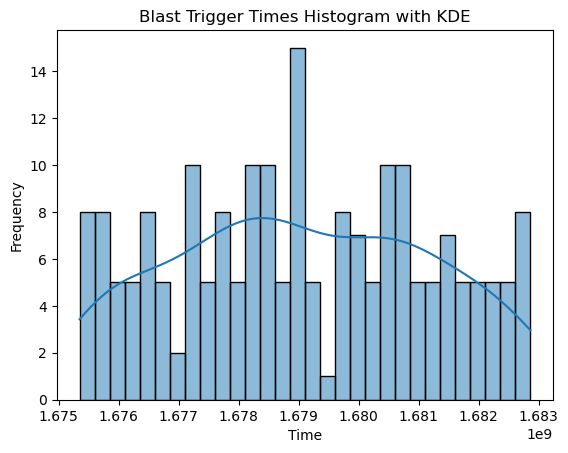

Fitting 110 distributions:  74%|███████▎  | 81/110 [00:08<00:13,  2.16it/s]SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
Fitting 110 distributions: 100%|██████████| 110/110 [00:48<00:00,  2.28it/s]

Best-fit Distribution: {'vonmises_line': {'kappa': 0.1436577823884246, 'loc': 1679107926.0166569, 'scale': 1202075.2506346232}}


In [13]:

from fitter import Fitter
# Convert blasting_times to numeric values (in seconds)
blasting_times_numeric = blasting_times.astype(np.int64) // 10**9

# Plot the histogram with KDE
sns.histplot(blasting_times_numeric, bins=30, kde=True)
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Blast Trigger Times Histogram with KDE')
plt.show()

# Fit the data to find the best distribution
fitter = Fitter(blasting_times_numeric)
fitter.fit()

# Get the best-fit distribution and its parameters
best_fit_distribution = fitter.get_best()

# Print the best-fit distribution and its parameters
print('Best-fit Distribution:', best_fit_distribution)

Its the Beta distribution .

The QQ plot (Quantile-Quantile plot) is used to assess whether a distribution follows a specific theoretical distribution, such as the Normal distribution. In the code, we create a QQ plot using the detected blasting times. By comparing the sample quantiles with the theoretical quantiles, we can visually assess if the distribution of blast trigger times follows a straight line, indicating a normal distribution. Deviations from a straight line may suggest deviations from normality.

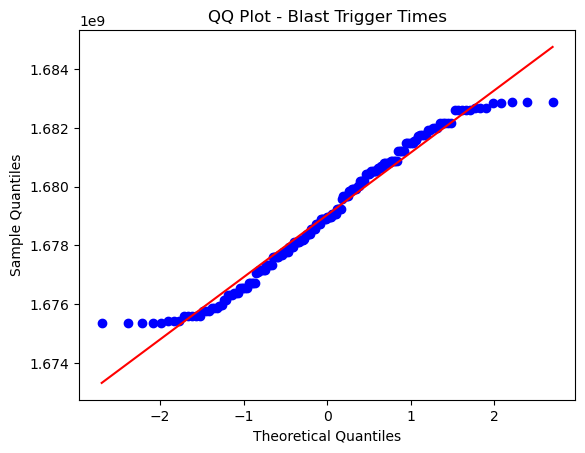

In [14]:
# Perform a QQ plot to assess normality
stats.probplot([blasting_time.timestamp() for blasting_time in blasting_times], dist='norm', plot=plt)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('QQ Plot - Blast Trigger Times')
plt.show()

Yes, we can calculate the probability of an open-pit blast happening during a specific time range. In the code, we define the desired time range (14:15 to 14:30) and calculate the probability by dividing the number of blasting times within that range by the total number of detected blasting times. This probability represents the likelihood of an open-pit blast occurring during the specified time range based on the available data.


In [15]:
blast_time = '14:15'
blast_end_time = '14:30'

blast_count = sum(blasting_time.time() == pd.to_datetime(blast_time).time() for blasting_time in blasting_times)
blast_probability = blast_count / len(blasting_times)

print(f"Probability of blast happening during {blast_time} to {blast_end_time}: {blast_probability}")


Probability of blast happening during 14:15 to 14:30: 0.21
